In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import geopandas as gpd

import cartopy.feature as cf
import cartopy.crs as ccrs

from matplotlib import patches
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.path.abspath("../../function"))
from others import haversine, relative_error, NMAE, NMSE, PSS, spearman_corr, MAE, RMSE

In [2]:
# product, date_ref = 'NOW', '2024_03_01'
product, date_ref = 'NRT', '2024_01_01'

In [3]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Brazil')

In [4]:
DATA = xr.open_dataset(os.path.join(dir_base,'GSMaP',product,f'GSMaP_{product}_SA_1dy_{date_ref}_2024_12_31.nc'))
DATA = DATA.sel(time=slice("2024-03-01", "2024-12-31"))

lon = DATA.lon.values
lat = DATA.lat[::-1].values
lon2d, lat2d = np.meshgrid(lon, lat)

GSMaP_time = DATA.time.values
print(f'Number of times: {len(GSMaP_time)}')

PRE = DATA.PRE.values

del DATA

Number of times: 306


In [5]:
DATA = xr.open_dataset('/home/arturo/Downloads/IMERG_BR/IMERG_Italy_1dy_2024_01_01_2024_12_31.nc')
DATA = DATA.sel(time=slice("2024-03-01", "2024-12-31"))

lat_IM = DATA.lat.values
lon_IM = DATA.lon.values
lon2d_IM, lat2d_IM = np.meshgrid(lon_IM, lat_IM)

IMERG = DATA.PRE.values

In [6]:
# obs_list = glob.glob(os.path.join(dir_base,'OBS_CPTEC','rdy','*.csv'))
# obs_list = sorted(obs_list)
# obs_len = len(obs_list)
# print(f'NUmber of files: {obs_len}')

INFO = pd.read_csv(os.path.join(dir_base,'OBS_CPTEC','INFO_final.csv'))
print(f'NUmber of files: {len(INFO)}')

NUmber of files: 3533


Text(0.0, 1.0, '(a) IMERG')

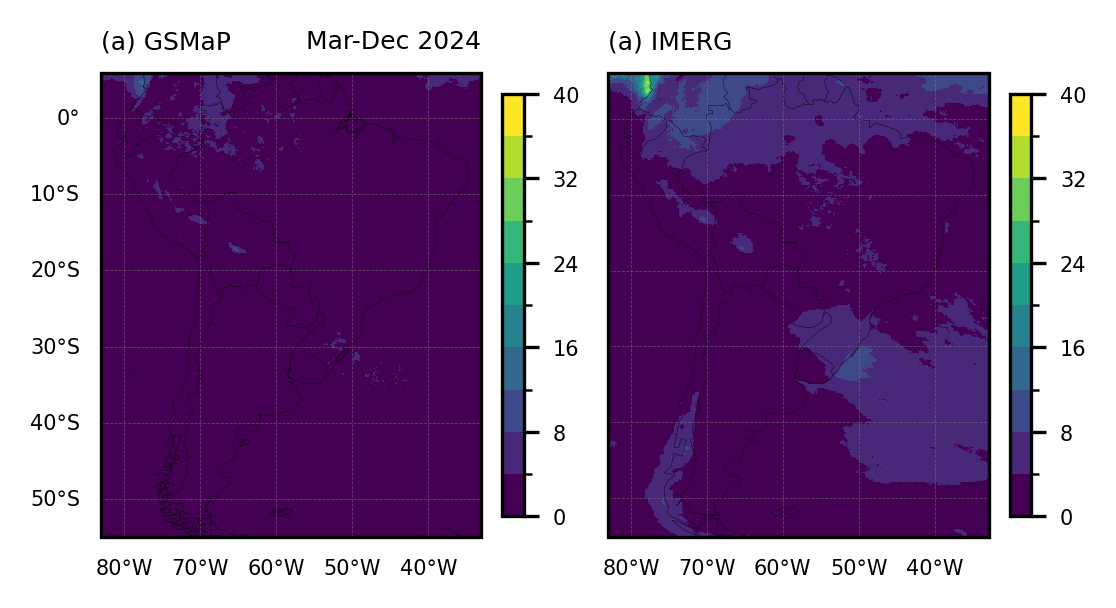

In [7]:
levels_obs = np.arange(0,44,4)
norm_obs = mcolors.BoundaryNorm(boundaries=levels_obs, ncolors=256)

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(4,4),dpi=300)
gs = gridspec.GridSpec(1,2)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(PRE,axis=0), norm=norm_obs)
cbar = plt.colorbar(a1,fraction=0.05)
cbar.ax.tick_params(labelsize=5) 

ax1.set_title('(a) GSMaP', loc='left', fontsize=6)
ax1.set_title('Mar-Dec 2024', loc='right', fontsize=6)

#==================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

a1 = ax1.pcolormesh(lon2d_IM, lat2d_IM, np.nanmean(IMERG,axis=0), norm=norm_obs)
cbar = plt.colorbar(a1,fraction=0.05)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(a) IMERG', loc='left', fontsize=6)

In [8]:
NMAE_all, NMSE_all, PSS_all = [], [], []
MAE_all, RMSE_all = [], []
lat_ref, lon_ref = [], []
COR_all = []
RE = []

for nn in range(len(INFO)):

    obs = pd.read_csv(os.path.join(dir_base,'OBS_CPTEC','final',INFO.File[nn]))
    
    obs['time'] = pd.to_datetime(obs['time'])
    obs = obs.drop_duplicates(subset='time', keep='first')

    start = '2024-03-01'
    end = '2024-12-31'

    obs_filtered = obs[(obs['time'] >= start) & (obs['time'] <= end)]
    obs_filtered = obs_filtered.reset_index(drop=True)

    PRE_obs = obs_filtered['pre'].values

    lat_obs = INFO.Lat.values[nn]
    lon_obs = INFO.Lon.values[nn]
    
    if lon_obs > -33:
        continue
    
    else:
        lat_ref.append(lat_obs)
        lon_ref.append(lon_obs)

        distances = haversine(lon2d, lat2d, lat_obs, lon_obs)
        min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

        # PRE_sat = IMERG[:,min_index[0],min_index[1]] # IMERG
        PRE_sat = PRE[:,min_index[0],min_index[1]] # GSMaP
        
        PRE_sat_rdy = PRE_sat[~np.isnan(PRE_obs)]
        PRE_obs_rdy = PRE_obs[~np.isnan(PRE_obs)]
        
        NMAE_tmp = NMAE(PRE_sat_rdy,PRE_obs_rdy)
        NMSE_tmp = NMSE(PRE_sat_rdy,PRE_obs_rdy)
        
        MAE_tmp = MAE(PRE_sat_rdy,PRE_obs_rdy)
        RMSE_tmp = RMSE(PRE_sat_rdy,PRE_obs_rdy)
        
        PSS_tmp = PSS(PRE_sat_rdy,PRE_obs_rdy)
        COR_tmp = spearman_corr(PRE_sat_rdy,PRE_obs_rdy)
        
        NMAE_all.append(float(NMAE_tmp))
        NMSE_all.append(float(NMSE_tmp))
        MAE_all.append(float(MAE_tmp))
        RMSE_all.append(float(RMSE_tmp))
        PSS_all.append(float(PSS_tmp))
        COR_all.append(float(COR_tmp))
        
        RE_ = relative_error(PRE_sat_rdy, PRE_obs_rdy)
        RE.append(RE_)

RE = np.concatenate([m.flatten() for m in RE])

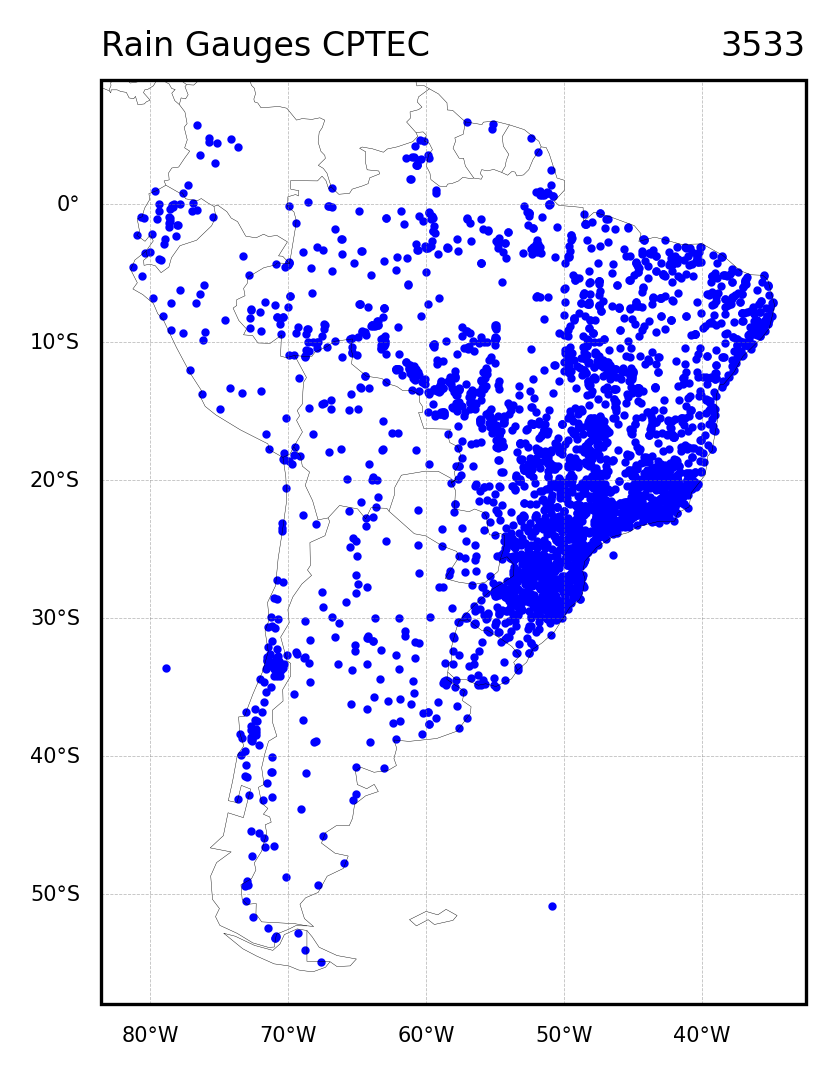

In [9]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(4,4),dpi=300)
gs = gridspec.GridSpec(1,1)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
# ax1.set_extent([SP_lon_min, SP_lon_max, SP_lat_min, SP_lat_max],crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

ax1.scatter(lon_ref,lat_ref,s=1,marker='o',color='b',transform=proj)
ax1.set_title('Rain Gauges CPTEC', fontsize=8, loc='left')
ax1.set_title(len(lon_ref), fontsize=8, loc='right')

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [10]:
# MAE_all = np.array(MAE_all)
# MAE_all = MAE_all[MAE_all<40]

# RMSE_all = np.array(RMSE_all)
# RMSE_all = RMSE_all[RMSE_all<60]

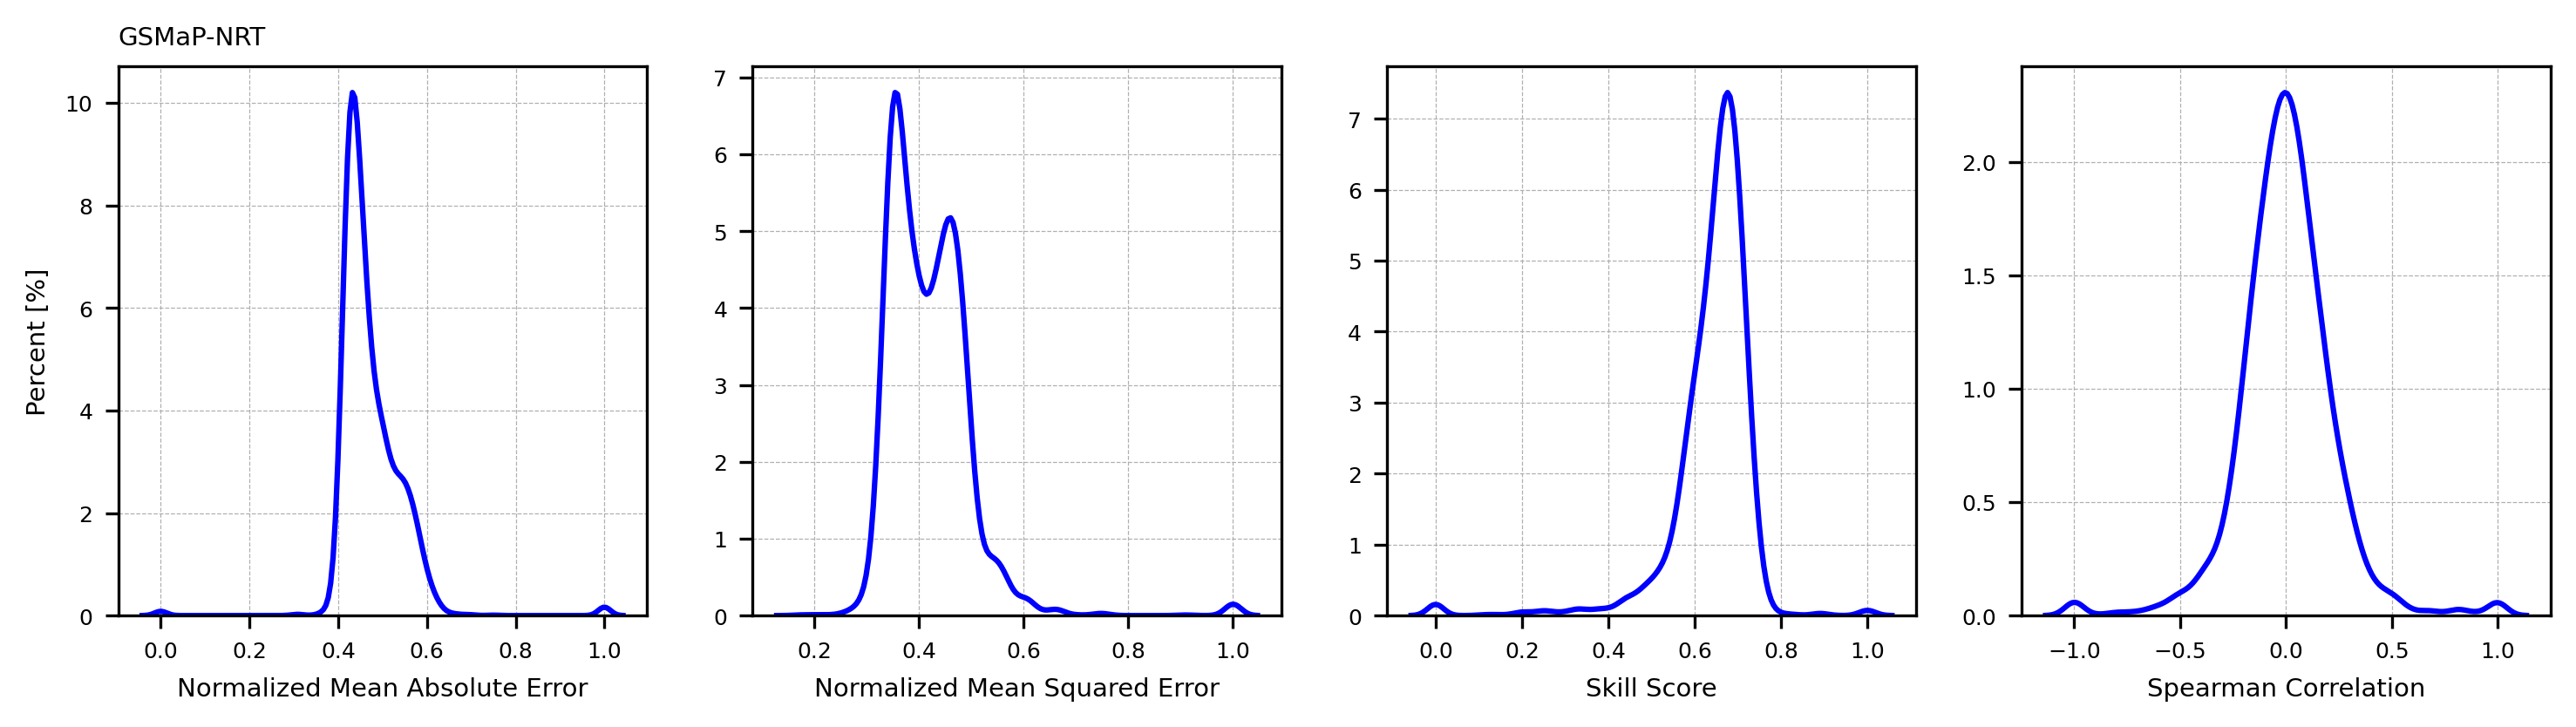

In [11]:
fig = plt.figure(figsize=(12,6),dpi=300)
gs = gridspec.GridSpec(2,4)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])
sns.kdeplot(NMAE_all,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.set_xlabel('Normalized Mean Absolute Error',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_title(f'GSMaP-{product}',fontsize=7, loc='left')

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 1])
sns.kdeplot(NMSE_all,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
ax1.set_xlabel('Normalized Mean Squared Error',fontsize=7)
ax1.set_ylabel('',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 2])
sns.kdeplot(PSS_all,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
ax1.set_xlabel('Skill Score',fontsize=7)
ax1.set_ylabel('',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 3])
sns.kdeplot(COR_all,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
ax1.set_ylabel('',fontsize=7)
ax1.set_xlabel('Spearman Correlation',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)

# # =========================================================================================================================
# ax1 = plt.subplot(gs[1, 0])
# sns.kdeplot(MAE_all,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
# ax1.set_ylabel('Percent [%]',fontsize=7)
# ax1.set_xlabel('Mean Absolute Error',fontsize=7)
# ax1.grid(linewidth=0.3, linestyle='--')
# ax1.tick_params(axis='both', which='major', labelsize=6)

# # =========================================================================================================================
# ax1 = plt.subplot(gs[1, 1])
# sns.kdeplot(RMSE_all,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
# ax1.set_xlabel('Root Mean Squared Error',fontsize=7)
# ax1.set_ylabel('',fontsize=7)
# ax1.grid(linewidth=0.3, linestyle='--')
# ax1.tick_params(axis='both', which='major', labelsize=6)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

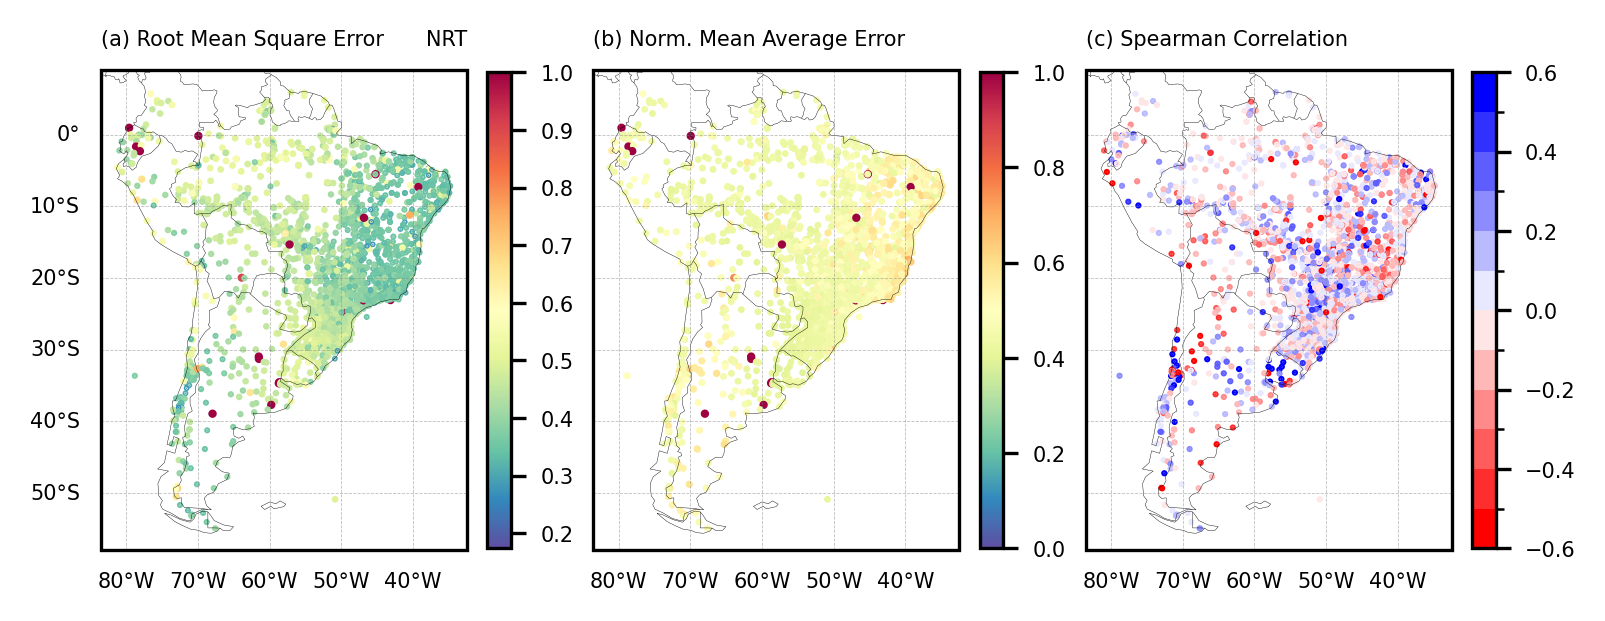

In [12]:
cmap = plt.cm.Spectral_r

cmap_cor = plt.cm.bwr_r
levels_cor = np.arange(-0.6,0.7,0.1)
norm_cor = mcolors.BoundaryNorm(boundaries=levels_cor, ncolors=256)

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(6,4),dpi=300)
gs = gridspec.GridSpec(1,3)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
# ax1.set_extent([SP_lon_min, SP_lon_max, SP_lat_min, SP_lat_max],crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

a1 = ax1.scatter(lon_ref,lat_ref,s=1*(NMSE_all-np.nanmin(NMSE_all))/(np.nanmax(NMSE_all)-np.nanmin(NMSE_all)),marker='o',c=NMSE_all,cmap=cmap)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(a) Root Mean Square Error', fontsize=5, loc='left')
ax1.set_title(product, fontsize=5, loc='right')

#==================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
# ax1.set_extent([SP_lon_min, SP_lon_max, SP_lat_min, SP_lat_max],crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

a1 = ax1.scatter(lon_ref,lat_ref,s=1*(NMAE_all-np.nanmin(NMAE_all))/(np.nanmax(NMAE_all)-np.nanmin(NMAE_all)),marker='o',c=NMAE_all,cmap=cmap)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(b) Norm. Mean Average Error', fontsize=5, loc='left')

#==================================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
# ax1.set_extent([SP_lon_min, SP_lon_max, SP_lat_min, SP_lat_max],crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

a1 = ax1.scatter(lon_ref,lat_ref,s=1,marker='.',c=COR_all,cmap=cmap_cor,norm=norm_cor)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

ax1.set_title('(c) Spearman Correlation', fontsize=5, loc='left')

ax1.set_facecolor('white')
fig.patch.set_alpha(0)